# NAME: Yucan Luo usc_id : 8085970332

# 1. Multi-class and Multi-Label Classification Using Support Vector Machines

# (a) Choose 70% of the data randomly as the training set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
### read the data 
data = pd.read_csv('../Anuran Calls (MFCCs)/Frogs_MFCCs.csv')

In [3]:
data.head(5)

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1


In [4]:
### we found out that first 22 col is x feaures and 23,24,25 col are labels

X = data.iloc[:, :22]
y = data.iloc[:, 22:25]

In [5]:
### to split the data into train and test (70-30)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
def split_data(X,y,label):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3,random_state=42)
    y_train_label = y_train.loc[:, label]
    y_test_label = y_test.loc[:, label]
    
    
    ### standardize the features 
    std = StandardScaler()
    X_train = pd.DataFrame(std.fit_transform(X_train))
    X_test = pd.DataFrame(std.transform(X_test))
    
    return X_train, X_test, y_train_label, y_test_label


In [6]:
### split the data respect to its labels 
X_train, X_test, y_train_family, y_test_family = split_data(X,y,'Family')
_, _, y_train_genus, y_test_genus = split_data(X,y,'Genus')
_, _, y_train_species, y_test_species = split_data(X,y,'Species')

In [8]:
#X_train

In [12]:
#print(y_train_family)

# (b) Each instance has three labels: Families, Genus, and Species. Each of the labels has multiple classes. We wish to solve a multi-class and multi-label problem. One of the most important approaches to multi-class classification is to train a classifier for each label. We first try this approach:


 # i. Research exact match and hamming score/ loss methods for evaluating multi- label classification and use them in evaluating the classifiers in this problem.

Exact matches: the predicted set of lablels should be exactly match with true set of lables.


Hamming score: the fraction of the correct labels to the total number of lables.


Hamming loss: the fraction of the wrong labels to the total number of labels. Hamming Loss =1- Hamming score




# ii. Train a SVM for each of the labels, using Gaussian kernels and one versus all classifiers. Determine the weight of the SVM penalty and the width of the Gaussian Kernel using 10 fold cross validation. You are welcome to try to solve the problem with both standardized and raw attributes and report the results

In [7]:

from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')


In [70]:

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score


def tunning_params(y_train_lable):
    
    ###set up space dictionary with specified hyperparameters
    space = {'C'     : hp.loguniform('C', -3, 3),
             'gamma' : hp.loguniform('gamma', -9, 0)}
    
    def f(params):
        clf = SVC(**params) ### the default for kernel is already 'rbf' and default decision classifier is 'ovr'
        best_score = cross_val_score(clf, X_train, y_train_lable, cv=10, 
                                     scoring='accuracy', n_jobs=-1).mean() # 10-fold cv
        return 1- best_score


    
    trials = Trials()
    # Run the algorithm
    best = fmin(fn=f,
                space=space, 
                max_evals=100, # Control how many evaluations to take
                algo=tpe.suggest,
                trials = trials)
    
    return best 
    
    

In [9]:
#### get the best_params for family after tunning

best_param_family =tunning_params(y_train_family)

100%|██████████| 100/100 [03:28<00:00,  2.08s/trial, best loss: 0.00675155416706108]


In [10]:
print(best_param_family)

{'C': 6.0802372629398835, 'gamma': 0.06473978469242313}


In [11]:
### refit the model for family 
svc_family = SVC(**best_param_family)  
svc_family.fit(X_train, y_train_family)
y_pred_family = svc_family.predict(X_test)


In [29]:
from sklearn.metrics import hamming_loss
hamming_loss_family =hamming_loss(y_pred_family, y_test_family)
hamming_score_family = 1- hamming_loss_family

print("the hamming_loss for label family is {}".format(hamming_loss_family))
print("the hamming_socre for lable family is {}".format(hamming_score_family))

the hamming_loss for label family is 0.006484483557202408
the hamming_socre for lable family is 0.9935155164427976


In [30]:
#### get the best_params for label genus after tuning 
best_param_genus = tunning_params(y_train_genus)

100%|██████████| 100/100 [04:24<00:00,  2.65s/trial, best loss: 0.009134478841238192]


In [42]:
print(best_param_genus)

{'C': 18.329707291797714, 'gamma': 0.04748189630991691}


In [33]:
### refit the model for genus label 
svc_genus = SVC(**best_param_genus)  
svc_genus.fit(X_train, y_train_genus)
y_pred_genus = svc_genus.predict(X_test)

In [35]:
hamming_loss_genus =hamming_loss(y_pred_genus, y_test_genus)
hamming_score_genus = 1- hamming_loss_genus

print("the hamming_loss for label genus is {}".format(hamming_loss_genus))
print("the hamming_socre for lable genus is {}".format(hamming_score_genus))

the hamming_loss for label genus is 0.009263547938860583
the hamming_socre for lable genus is 0.9907364520611395


In [36]:
#### get the best_params for label species after tuning 
best_param_species = tunning_params(y_train_species)

100%|██████████| 100/100 [04:01<00:00,  2.42s/trial, best loss: 0.009928918552178922]


In [38]:
print(best_param_species)

{'C': 15.196147963209235, 'gamma': 0.03174314506698205}


In [39]:
### refit the model for species label 
svc_species = SVC(**best_param_species)  
svc_species.fit(X_train, y_train_species)
y_pred_species = svc_species.predict(X_test)

In [40]:
hamming_loss_species =hamming_loss(y_pred_species, y_test_species)
hamming_score_species = 1- hamming_loss_species

print("the hamming_loss for label species is {}".format(hamming_loss_species))
print("the hamming_socre for lable species is {}".format(hamming_score_species))

the hamming_loss for label species is 0.012505789717461788
the hamming_socre for lable species is 0.9874942102825383


In [41]:
#### multi-label evaluation ###
y_test = np.column_stack((y_test_family, y_test_genus, y_test_species))
y_pred = np.column_stack((y_pred_family, y_pred_genus, y_pred_species))

In [54]:
def accuracy_score_multi(y_test, y_pred):
    return np.sum(np.all(np.equal(y_test, y_pred), axis=1)) / y_test.shape[0]

def hamming_score_multi(y_test, y_pred):
    return np.mean((np.sum((np.equal(y_test, y_pred)), axis=1) / y_test.shape[1]))

In [66]:
exact = hamming_score_multi(y_test, y_pred)
print("the accuracy score for multi lable (exact match) is {}".format(exact))

hamming_loss_multi = 1- hamming_score_multi(y_test,y_pred)
print("the hamming loss for multi lable is {}".format(hamming_loss_multi))

the accuracy score for multi lable (exact match) is 0.9905820595954918
the hamming loss for multi lable is 0.009417940404508163


# iii. Repeat 1(b)ii with L1-penalized SVM Remember to standardize the attributes. Determine the weight of the SVM penalty using 10 fold cross validation.

In [124]:
###L1-penalized Linear SVM, since we alread standardized the features we can use it directly ###

from sklearn.linear_model import SGDClassifier 

def l1_opt_linear(y_train_lable):
    
    ###set up space dictionary with specified hyperparameters
    space = {'alpha'     : hp.loguniform('alpha', -6, 3),}
    
    def fc(params):
        clf = SGDClassifier(**params,penalty='l1',early_stopping= True,n_jobs=-1) 
        best_score = cross_val_score(clf, X_train, y_train_lable, cv=10, 
                                     scoring='accuracy', n_jobs=-1).mean() # 10-fold cv
        return 1- best_score

    
    trials = Trials()
    # Run the algorithm
    best = fmin(fn=fc,
                space=space, 
                max_evals=100, # Control how many evaluations to take
                algo=tpe.suggest,
                trials = trials)
    
    return best 
    

In [125]:
l1_best_param_family = l1_opt_linear(y_train_family)

100%|██████████| 100/100 [00:58<00:00,  1.70trial/s, best loss: 0.06592350657957025]


In [126]:
print("after 10 fold validation ",l1_best_param_family)

after 10 fold validation  {'alpha': 0.0025999825722382106}


In [127]:
### refit the model for family 
l1_family = SGDClassifier(**l1_best_param_family,penalty='l1',early_stopping= True,n_jobs=-1)  
l1_family.fit(X_train, y_train_family)
y_pred_family_l1 = l1_family.predict(X_test)

In [128]:
hamming_loss_family_l1 =hamming_loss(y_pred_family_l1, y_test_family)
hamming_score_family_l1 = 1- hamming_loss_family_l1

print("the hamming_loss for label family with l1 penalty is {}".format(hamming_loss_family_l1))
print("the hamming_socre for lable family with l1 penalty is {}".format(hamming_score_family_l1))

the hamming_loss for label family with l1 penalty is 0.07179249652616952
the hamming_socre for lable family with l1 penalty is 0.9282075034738305


In [129]:
l1_best_param_genus = l1_opt_linear(y_train_genus)

100%|██████████| 100/100 [01:22<00:00,  1.22trial/s, best loss: 0.07327384896967393]


In [130]:
print("after 10 fold validation the choosen alpha is  ",l1_best_param_genus)

after 10 fold validation the choosen alpha is   {'alpha': 0.002523845688237745}


In [131]:
### refit the model for genus
l1_genus = SGDClassifier(**l1_best_param_genus,penalty='l1',early_stopping= True,n_jobs=-1)  
l1_genus.fit(X_train, y_train_genus)
y_pred_genus_l1 = l1_genus.predict(X_test)

In [132]:
hamming_loss_genus_l1 =hamming_loss(y_pred_genus_l1, y_test_genus)
hamming_score_genus_l1 = 1- hamming_loss_genus_l1

print("the hamming_loss for label genus with l1 penalty is {}".format(hamming_loss_genus_l1))
print("the hamming_socre for lable genus with l1 penalty is {}".format(hamming_score_genus_l1))

the hamming_loss for label genus with l1 penalty is 0.08383510884668828
the hamming_socre for lable genus with l1 penalty is 0.9161648911533117


In [133]:
l1_best_param_species = l1_opt_linear(y_train_species)

100%|██████████| 100/100 [01:36<00:00,  1.03trial/s, best loss: 0.054206901448452194]


In [134]:
print("after 10 fold validation the choosen alpha is  ",l1_best_param_genus)

after 10 fold validation the choosen alpha is   {'alpha': 0.002523845688237745}


In [135]:
### refit the model for species 
l1_species = SGDClassifier(**l1_best_param_species,penalty='l1',early_stopping= True,n_jobs=-1)  
l1_species.fit(X_train, y_train_species)
y_pred_species_l1 = l1_species.predict(X_test)

In [136]:
hamming_loss_species_l1 =hamming_loss(y_pred_species_l1, y_test_species)
hamming_score_species_l1 = 1- hamming_loss_species_l1

print("the hamming_loss for label species with l1 penalty is {}".format(hamming_loss_species_l1))
print("the hamming_socre for lable species with l1 penalty is {}".format(hamming_score_species_l1))

the hamming_loss for label species with l1 penalty is 0.06947660954145438
the hamming_socre for lable species with l1 penalty is 0.9305233904585456


In [137]:
#### multi-label evaluation ###
y_test = np.column_stack((y_test_family, y_test_genus, y_test_species))
y_pred_l1 = np.column_stack((y_pred_family_l1, y_pred_genus_l1, y_pred_species_l1))

In [138]:
exact_l1 = hamming_score_multi(y_test, y_pred_l1)
print("the accuracy score with l1 penalty for multi lable (exact match) is {}".format(exact_l1))

hamming_loss_multi_l1 = 1- hamming_score_multi(y_test,y_pred_l1)
print("the hamming loss with l1 penalty for multi lable is {}".format(hamming_loss_multi_l1))

the accuracy score with l1 penalty for multi lable (exact match) is 0.9249652616952293
the hamming loss with l1 penalty for multi lable is 0.0750347383047707


so , for linear kernel with the l1 penalty, we can see that hamming loss increases a little(worse) compared to SVM with Guassian kernel.

# iv. Repeat 1(b)iii by using SMOTE or any other method you know to remedy class imbalance. Report your conclusions about the classifiers you trained.

In [93]:
from imblearn.over_sampling import SMOTE
###to apply smote on training set 
sm = SMOTE(random_state=42)
X_train_family_sm, y_train_family_sm = sm.fit_resample(X_train, y_train_family)
X_train_genus_sm, y_train_genus_sm = sm.fit_resample(X_train, y_train_genus)
X_train_species_sm, y_train_species_sm = sm.fit_resample(X_train, y_train_species)


In [108]:
def sm_l1_opt_linear(X_train, y_train_lable):
    
    ###set up space dictionary with specified hyperparameters
    space = {'alpha'     : hp.loguniform('alpha', -6, 3)}
    
    def fc(params):
        clf = SGDClassifier(**params,penalty='l1',early_stopping= True,n_jobs=-1) 
        best_score = cross_val_score(clf, X_train, y_train_lable, cv=10, 
                                     scoring='accuracy', n_jobs=-1).mean() # 10-fold cv
        return 1- best_score

    
    trials = Trials()
    # Run the algorithm
    best = fmin(fn=fc,
                space=space, 
                max_evals=100, # Control how many evaluations to take
                algo=tpe.suggest,
                trials = trials)
    
    return best 

In [109]:
sm_best_param_family = sm_l1_opt_linear(X_train_family_sm, y_train_family_sm)

100%|██████████| 100/100 [01:55<00:00,  1.16s/trial, best loss: 0.05515628410962703]


In [110]:
print("after apply smote the alpha chosen ", sm_best_param_family)

after apply smote the alpha chosen  {'alpha': 0.0025063642692590665}


In [111]:
### refit the model for family 
sm_family = SGDClassifier(**sm_best_param_family,penalty='l1',early_stopping= True,n_jobs=-1)  
sm_family.fit(X_train_family_sm, y_train_family_sm)
y_pred_family_sm = sm_family.predict(X_test)

In [112]:
hamming_loss_family_sm =hamming_loss(y_pred_family_sm, y_test_family)
hamming_score_family_sm = 1- hamming_loss_family_sm

print("after smote the hamming_loss for label family with l1 penalty is {}".format(hamming_loss_family_sm))
print("after smote the hamming_socre for lable family with l1 penalty is {}".format(hamming_score_family_sm))

after smote the hamming_loss for label family with l1 penalty is 0.09031959240389069
after smote the hamming_socre for lable family with l1 penalty is 0.9096804075961094


In [113]:
sm_best_param_genus = sm_l1_opt_linear(X_train_genus_sm,y_train_genus_sm)

100%|██████████| 100/100 [04:27<00:00,  2.68s/trial, best loss: 0.06726433435934032]


In [114]:
print("after apply smote the alpha chosen ", sm_best_param_genus)

after apply smote the alpha chosen  {'alpha': 0.0027878799916807905}


In [115]:
### refit the model for genus 
sm_genus = SGDClassifier(**sm_best_param_genus,penalty='l1',early_stopping= True,n_jobs=-1)  
sm_genus.fit(X_train_genus_sm, y_train_genus_sm)
y_pred_genus_sm = sm_genus.predict(X_test)

In [116]:
hamming_loss_genus_sm =hamming_loss(y_pred_genus_sm, y_test_genus)
hamming_score_genus_sm = 1- hamming_loss_genus_sm

print("after smote, the hamming_loss for label genus with l1 penalty is {}".format(hamming_loss_genus_sm))
print("after smote, the hamming_socre for lable genus with l1 penalty is {}".format(hamming_score_genus_sm))

after smote, the hamming_loss for label genus with l1 penalty is 0.1000463177396943
after smote, the hamming_socre for lable genus with l1 penalty is 0.8999536822603057


In [117]:
sm_best_param_species = sm_l1_opt_linear(X_train_species_sm,y_train_species_sm)

100%|██████████| 100/100 [05:49<00:00,  3.49s/trial, best loss: 0.05827543931344503]


In [118]:
print("after apply smote the alpha chosen ", sm_best_param_species)

after apply smote the alpha chosen  {'alpha': 0.002515687358386086}


In [119]:
### refit the model for species 
sm_species = SGDClassifier(**sm_best_param_species,penalty='l1',early_stopping= True,n_jobs=-1)  
sm_species.fit(X_train_species_sm, y_train_species_sm)
y_pred_species_sm = sm_species.predict(X_test)

In [121]:
hamming_loss_species_sm =hamming_loss(y_pred_species_sm, y_test_species)
hamming_score_species_sm = 1- hamming_loss_species_sm

print("after smote, the hamming_loss for label speices with l1 penalty is {}".format(hamming_loss_species_sm))
print("after smote, the hamming_socre for lable speices with l1 penalty is {}".format(hamming_score_species_sm))

after smote, the hamming_loss for label speices with l1 penalty is 0.05604446503010653
after smote, the hamming_socre for lable speices with l1 penalty is 0.9439555349698935


In [122]:
#### multi-label evaluation ###
y_test = np.column_stack((y_test_family, y_test_genus, y_test_species))
y_pred_sm = np.column_stack((y_pred_family_sm, y_pred_genus_sm, y_pred_species_sm))

In [123]:
exact_sm = hamming_score_multi(y_test, y_pred_sm)
print("after smote,the accuracy score with l1 penalty for multi lable (exact match) is {}".format(exact_sm))

hamming_loss_multi_sm = 1- hamming_score_multi(y_test,y_pred_sm)
print("after smote the hamming loss with l1 penalty for multi lable is {}".format(hamming_loss_multi_sm))

after smote,the accuracy score with l1 penalty for multi lable (exact match) is 0.9178632082754361
after smote the hamming loss with l1 penalty for multi lable is 0.0821367917245639


so we can see that the hamming loss increase a little after applying smote to the training data.

# 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

# (a) Use k-means clustering on the whole Anuran Calls (MFCCs) Data Set (do not split the data into train and test, as we are not performing supervised learning in this exercise). Choose k automatically based on one of the methods provided in the slides (CH or Gap Statistics or scree plots or Silhouettes) or any other method you know.

In [4]:
### this time we don't split the dataset 
### we only care about x 

#data.head()

X_data = data.iloc[:,:-4] ### get rid of y lables 
y_data = data.iloc[:,22:25]

In [5]:

from sklearn.cluster import MiniBatchKMeans # for large size data less computational intensive 
from sklearn.metrics import silhouette_score

In [6]:
def k_means_silhouette(k, x):
    cluster = MiniBatchKMeans(n_clusters=k, random_state=42)
    
    cluster_label = cluster.fit_predict(x)
    
    score = silhouette_score(x, cluster_label, metric="euclidean")
    
    
    return score 

In [7]:
k_range = [*range(2,51)] ## k start at 2 otherwise there's no menaing 
### initial the k and silhouette score 
k_score = [0,0] 
for k in k_range:
    
    score = k_means_silhouette(k,X_data)
    
    if score > k_score[1]: ### find the max score and store it's k 
        k_score = [k,score]

In [9]:
print("using silhouette score, the best k is : {} and the sihouette score is {}".format(k_score[0], k_score[1]))

using silhouette score, the best k is : 7 and the sihouette score is 0.37426410258135157


# (b) In each cluster, determine which family is the majority by reading the true labels. Repeat for genus and species.

In [10]:
### refit the minibatchkmeans using best k 
best_k = k_score[0]
cluster = MiniBatchKMeans(n_clusters=best_k, random_state=42)
cluster_label = cluster.fit_predict(X_data)

In [11]:
y_data["label"] = cluster_label

In [13]:
### for each cluster get the majority family 

frequent_family = y_data.groupby("label")["Family"].agg(pd.Series.mode)

In [14]:
frequent_family

label
0    Leptodactylidae
1    Leptodactylidae
2      Dendrobatidae
3            Hylidae
4            Hylidae
5    Leptodactylidae
6    Leptodactylidae
Name: Family, dtype: object

majority label in each cluster shown as above for Family

# Repeat for genus and species.

In [15]:
frequent_genus = y_data.groupby("label")['Genus'].agg(pd.Series.mode)
frequent_genus 

label
0    Leptodactylus
1        Adenomera
2         Ameerega
3        Hypsiboas
4        Hypsiboas
5        Adenomera
6        Adenomera
Name: Genus, dtype: object

majority label in each cluster shown as above for Genus

In [16]:
frequent_species = y_data.groupby("label")['Species'].agg(pd.Series.mode)
frequent_species 

label
0       LeptodactylusFuscus
1    AdenomeraHylaedactylus
2        Ameeregatrivittata
3      HypsiboasCinerascens
4         HypsiboasCordobae
5            AdenomeraAndre
6            AdenomeraAndre
Name: Species, dtype: object

majority label in each cluster shown as above for Species

# (c) Now for each cluster you have a majority label triplet (family, genus, species). Calculate the average Hamming distance, Hamming score, and Hamming loss between the true labels and the labels assigned by clusters.

In [17]:

### assign majority label triplet to that cluster for family , genus and species 
y_data['Pred_Family'] = y_data['label'].map(frequent_family)
y_data['Pred_Genus'] = y_data['label'].map(frequent_genus)
y_data['Pred_Species'] = y_data['label'].map(frequent_species)

In [22]:
y_data.head()

,Family,Genus,Species,label,Pred_Family,Pred_Genus,Pred_Species
0,Leptodactylidae,Adenomera,AdenomeraAndre,6,Leptodactylidae,Adenomera,AdenomeraAndre
1,Leptodactylidae,Adenomera,AdenomeraAndre,6,Leptodactylidae,Adenomera,AdenomeraAndre
2,Leptodactylidae,Adenomera,AdenomeraAndre,6,Leptodactylidae,Adenomera,AdenomeraAndre
3,Leptodactylidae,Adenomera,AdenomeraAndre,6,Leptodactylidae,Adenomera,AdenomeraAndre
4,Leptodactylidae,Adenomera,AdenomeraAndre,6,Leptodactylidae,Adenomera,AdenomeraAndre


In [24]:
### first three columns are actual labels
actual_label = [x.iloc[:, :3].values for _, x in y_data.groupby('label')] 
### last three columns are assigned labels
assign_label = [x.iloc[:, 4:].values for _, x in y_data.groupby('label')]

In [41]:

def get_ham_distance(x):
    ### if actural label not equal to assigned label, then distance +=1
    return np.mean(np.sum(np.not_equal(x[0], x[1]), axis=1))

def get_ham_score(x):
    ### if assigned label equal to actual label, ham_score = correnct label / total label
    return np.mean((np.sum((np.equal(x[0], x[1])), axis=1) / x[0].shape[1]))

In [44]:
### get the hamming distance , hamming score ###
hamming_dist = np.mean(list(map(get_ham_distance, zip(actual_label, assign_label))))
hamming_score = np.mean(list(map(get_ham_score, zip(actual_label, assign_label))))
hamming_loss = 1- hamming_score

In [46]:
print("the average hamming distance is {}".format(hamming_dist))
print("the average hamming_socre is {}".format(hamming_score))
print("the average hamming_loss is {}".format(hamming_loss))

the average hamming distance is 0.7246666381417686
the average hamming_socre is 0.7584444539527438
the average hamming_loss is 0.24155554604725615


# Monte-Carlo Simulation: Perform the following procedures 50 times, and report the average and standard deviation of the 50 Hamming Distances that you calculate

In [86]:
def get_k(x):
    
    ### each time find k from range {1,2,3,...50}
    k_range= [*range(2,51)]
    k_score = [0,0]
    for k in k_range:
        ### without random state to make sure each time generate different result 
        cluster = MiniBatchKMeans(n_clusters=k) 
    
        cluster_label = cluster.fit_predict(x)
    
        score = silhouette_score(x, cluster_label, metric="euclidean")
        
        if score > k_score[1]:
            k_score = [k,score]
            
    ##after find best k and it's score ###
    
    best_k = k_score[0]
    
    return best_k
    

In [91]:
### refit the model and get hamming socre hamming loss and hamming distance 
def refit_model(x,y):
    ### get the best k from k_range 
    best_k = get_k(x)
    ### refit the minibatchkmeans using best k 
    cluster = MiniBatchKMeans(n_clusters=best_k)
    cluster_label = cluster.fit_predict(x)
    
    y["label"] = cluster_label
    
    frequent_family = y.groupby("label")["Family"].agg(pd.Series.mode)
    frequent_genus = y.groupby("label")['Genus'].agg(pd.Series.mode)
    frequent_species = y.groupby("label")['Species'].agg(pd.Series.mode)
    ### assign majority label triplet to that cluster for family , genus and species 
    y['Pred_Family'] = y['label'].map(frequent_family)
    y['Pred_Genus'] = y['label'].map(frequent_genus)
    y['Pred_Species'] = y['label'].map(frequent_species)
    ### first three columns are actual labels
    actual_label = [x.iloc[:, :3].values for _, x in y.groupby('label')] 
    ### last three columns are assigned labels
    assign_label = [x.iloc[:, 4:].values for _, x in y.groupby('label')]
    
    ### get the average hamming distance , average hamming score ###
    ham_dist = np.mean(list(map(get_ham_distance, zip(actual_label, assign_label))))
    ham_score = np.mean(list(map(get_ham_score, zip(actual_label, assign_label))))
    ham_loss = 1- ham_score
    
    return [ham_dist,ham_score,ham_loss]
    

    

In [95]:
####  Monte-Carlo Simulation 50 times ####
ham_50 = []

X_data = data.iloc[:,:-4] ### get rid of y lables 
y_data = data.iloc[:,22:25]

for i in range(50):
    
    if i == 25:
        print("comlete 50%")
        
    if i == 49:
        print("complet")
    all_scores= refit_model(X_data,y_data)
    
    ham_50.append(all_scores)
    

    
  

comlete 50%
complet


In [100]:
three_scores= np.array(ham_50)

In [101]:
three_scores.shape

(50, 3)

In [103]:
df_scores = pd.DataFrame(three_scores, columns =["Hamming_distance","Hamming_score","Hamming_Loss"])

In [105]:
df_scores.head()

,Hamming_distance,Hamming_score,Hamming_Loss
0,0.833471,0.722176,0.277824
1,0.623222,0.792259,0.207741
2,1.151217,0.616261,0.383739
3,0.957177,0.680941,0.319059
4,0.821420,0.726193,0.273807


In [114]:
### get mean and std for each score 

df = df_scores.describe().T[[ 'mean', 'std']]

In [115]:
df.T

,Hamming_distance,Hamming_score,Hamming_Loss
mean,0.887934,0.704022,0.295978
std,0.138806,0.046269,0.046269


after 50 times simulation, we got the mean and std for Hamming distance, Hamming_score and Hamming_loss as above

# 3. ISLR 10.7.2

(a) On the basis of this dissimilarity matrix, sketch the dendrogram that results from hierarchically clustering these four observa- tions using complete linkage. Be sure to indicate on the plot the height at which each fusion occurs, as well as the observations corresponding to each leaf in the dendrogram.



In [1]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance_matrix
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform

In [11]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram ')
        plt.xlabel('sample index')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

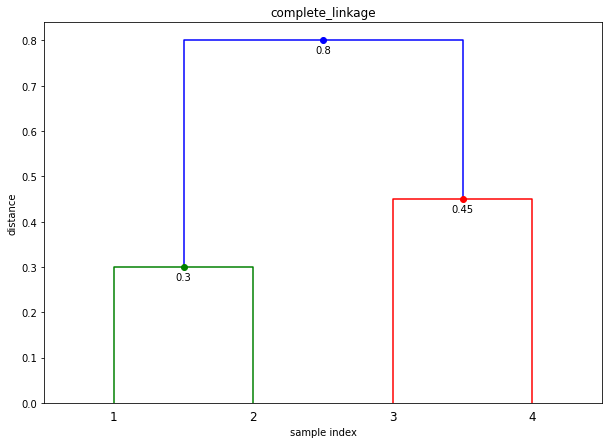

In [12]:
X= np.array([[0,0.3,0.4,0.7],[0.3,0,0.5,0.8],[0.4,0.5,0,0.45],[0.7,0.8,0.45,0]])
dists = squareform(X)
linkage_matrix = linkage(dists, "complete")
plt.figure(figsize=(10, 7))
fancy_dendrogram(linkage_matrix, labels=["1", "2", "3","4"],\
           distance_sort="descending", \
           show_leaf_counts=True,\
           )
plt.title("complete_linkage")
plt.show()

(b) Repeat (a), this time using single linkage clustering.

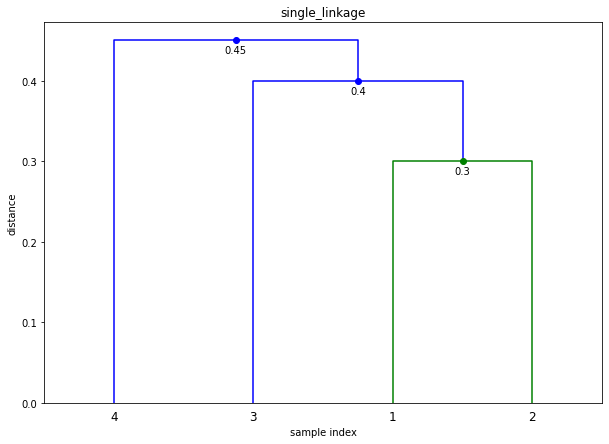

In [13]:
X= np.array([[0,0.3,0.4,0.7],[0.3,0,0.5,0.8],[0.4,0.5,0,0.45],[0.7,0.8,0.45,0]])
dists = squareform(X)
linkage_matrix = linkage(dists, "single")
plt.figure(figsize=(10, 7))
fancy_dendrogram(linkage_matrix, labels=["1", "2", "3","4"],\
           distance_sort="descending", \
           show_leaf_counts=True,\
           )
plt.title("single_linkage")
plt.show()

(c) Suppose that we cut the dendogram obtained in (a) such that two clusters result. Which observations are in each cluster?

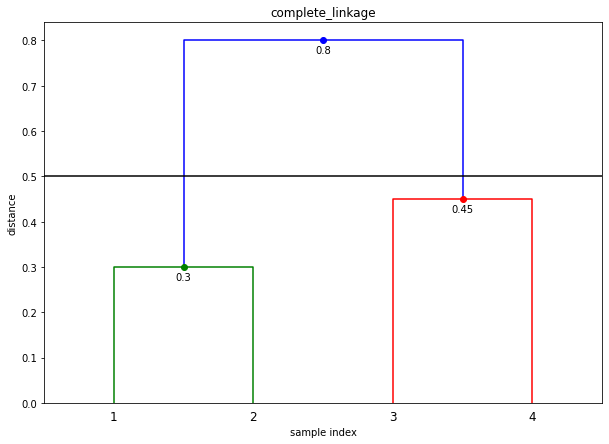

In [14]:
X= np.array([[0,0.3,0.4,0.7],[0.3,0,0.5,0.8],[0.4,0.5,0,0.45],[0.7,0.8,0.45,0]])
dists = squareform(X)
linkage_matrix = linkage(dists, "complete")
plt.figure(figsize=(10, 7))
fancy_dendrogram(linkage_matrix, labels=["1", "2", "3","4"],\
           distance_sort="descending", \
           show_leaf_counts=True,\
           max_d = 0.5
           )
plt.title("complete_linkage")
plt.show()

If we cut the dendogram in (a), we will have two culsters, one cluster is  (1,2) and another is (3,4)

(d) Suppose that we cut the dendogram obtained in (b) such that two clusters result. Which observations are in each cluster?

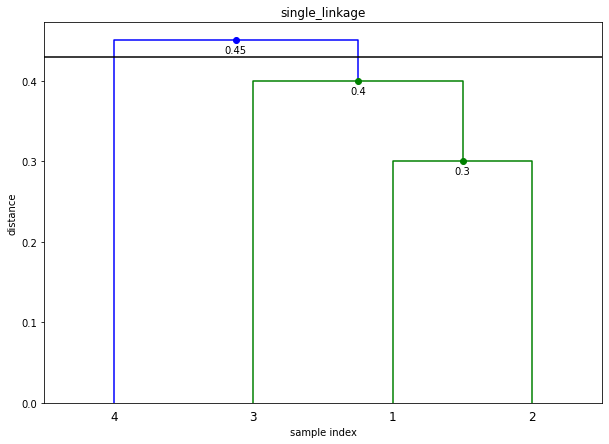

In [15]:
X= np.array([[0,0.3,0.4,0.7],[0.3,0,0.5,0.8],[0.4,0.5,0,0.45],[0.7,0.8,0.45,0]])
dists = squareform(X)
linkage_matrix = linkage(dists, "single")
plt.figure(figsize=(10, 7))
fancy_dendrogram(linkage_matrix, labels=["1", "2", "3","4"],\
           distance_sort="descending", \
           show_leaf_counts=True,\
           max_d = 0.43
           )
plt.title("single_linkage")
plt.show()

If we cut the dendogram in (b), we will have two culsters, one cluster is (1,2,3) and another is (4)

(e) It is mentioned in the chapter that at each fusion in the den- drogram, the position of the two clusters being fused can be swapped without changing the meaning of the dendrogram. Draw a dendrogram that is equivalent to the dendrogram in (a), for which two or more of the leaves are repositioned, but for which the meaning of the dendrogram is the same.


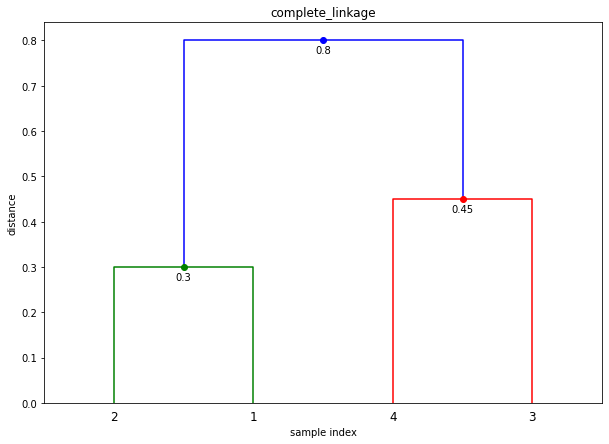

In [17]:
X= np.array([[0,0.3,0.4,0.7],[0.3,0,0.5,0.8],[0.4,0.5,0,0.45],[0.7,0.8,0.45,0]])
dists = squareform(X)
linkage_matrix = linkage(dists, "complete")
plt.figure(figsize=(10, 7))
fancy_dendrogram(linkage_matrix, labels=["2", "1", "4","3"],\
           distance_sort="descending", \
           show_leaf_counts=True,\
           )
plt.title("complete_linkage")
plt.show()